In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
from sklearn.model_selection import train_test_split
np.random.seed(42)
import scipy.stats as stats
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from datetime import timedelta  



from matplotlib import rcParams
rcParams.update({'figure.autolayout':True})

plt.style.use(["presentation"])

%matplotlib inline

In [135]:


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, ElasticNet, Ridge, RidgeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense

In [136]:
test=pd.read_pickle('./assets/test_step1')

In [137]:
train=pd.read_pickle('./assets/train_step1')

In [138]:
pred=pd.read_pickle('./assets/prediction_step1')

In [139]:
NOAA=pd.read_pickle('./assets/NOAA')

# A. More feature engineering

In [140]:
# Found a paper, https://parasitesandvectors.biomedcentral.com/articles/10.1186/1756-3305-6-129,
# that says that length of day for the last 30 days and the wind speed for the past 20 days
# are both important to predicting Culex pipiens.  So let's get that weather data.


In [167]:
test['day']=test['Date'].map(lambda x: x.dayofyear)
train['day']=train['Date'].map(lambda x: x.dayofyear)
pred['day']=pred['Date'].map(lambda x: x.dayofyear)


In [168]:
test['day2']=test['day']**2
train['day2']=train['day']**2
pred['day2']=pred['day']**2

In [145]:
def convert(x):
    if x[-2:]=='60':
        x=re.sub('60$', '59', x)
    x=pd.to_datetime(x, format='%H%M')
    return x



In [146]:
NOAA['Sunset']=NOAA['Sunset'].map(convert)
NOAA['Sunrise']=NOAA['Sunrise'].map(convert)

In [147]:
NOAA['Daylength']=(NOAA['Sunset']-NOAA['Sunrise']).astype('timedelta64[m]')

In [148]:
def measure_recent_days(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=30)))&(NOAA['Date']<=A)]['Daylength'].mean()

In [149]:
train['recent_day_length']=train['Date'].map(measure_recent_days)

In [150]:
test['recent_day_length']=test['Date'].map(measure_recent_days)

In [151]:
pred['recent_day_length']=pred['Date'].map(measure_recent_days)

In [152]:
# Create a quadratic term for day length

train['day_length_2']=train['recent_day_length']**2
test['day_length_2']=test['recent_day_length']**2
pred['day_length_2']=pred['recent_day_length']**2


In [153]:
new_vals = []

for i, x in enumerate(NOAA['AvgSpeed']):
    if x == 'M':
        new_vals.append(NOAA['AvgSpeed'].loc[i+1])
    else:
        new_vals.append(x)
        
NOAA['AvgSpeed'] = new_vals
NOAA['AvgSpeed'] = NOAA['AvgSpeed'].astype(float)

In [154]:
def measure_recent_wind(A):
    return NOAA.loc[(NOAA['Date']>(A-timedelta(days=20)))&(NOAA['Date']<=A)]['AvgSpeed'].mean()

In [155]:
train['recent_wind']=train['Date'].map(measure_recent_wind)

In [156]:
test['recent_wind']=test['Date'].map(measure_recent_wind)

In [157]:
pred['recent_wind']=pred['Date'].map(measure_recent_wind)

In [287]:
# The east-west axis might be relevant due to the presence of Lake Michigan.

In [196]:
train['east_west']=train['Location'].map(lambda x: x[1])

In [197]:
test['east_west']=test['Location'].map(lambda x: x[1])

In [198]:
pred['east_west']=pred['Location'].map(lambda x: x[1])

In [199]:
train.to_pickle('./assets/train_step2')

In [200]:
test.to_pickle('./assets/test_step2')

In [201]:
pred.to_pickle('./assets/pred_step2')

## A.1 A little EDA on the new features

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


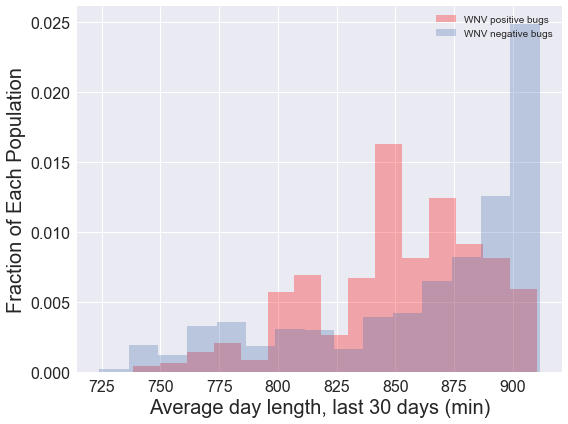

In [178]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['recent_day_length'].hist(bins=15, alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['recent_day_length'].hist(bins=15, alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Average day length, last 30 days (min)')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./EDA1.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


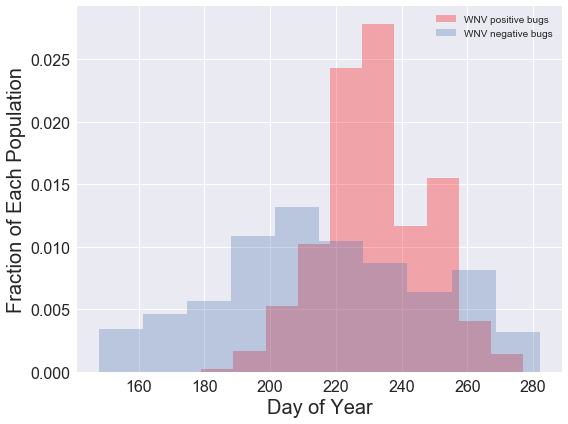

In [176]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['day'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['day'].hist(alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Day of Year')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./EDA2.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


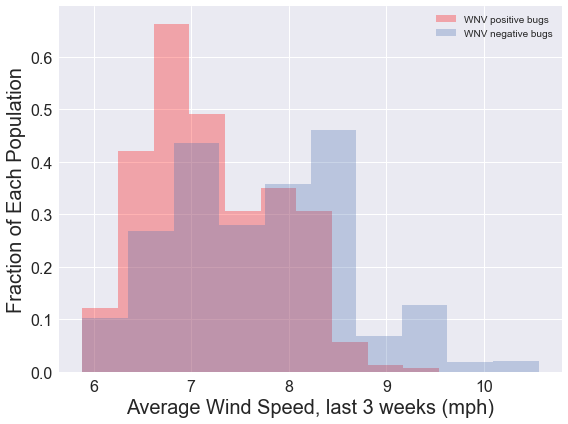

In [180]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['recent_wind'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['recent_wind'].hist( alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Average Wind Speed, last 3 weeks (mph)')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./timing.png")

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


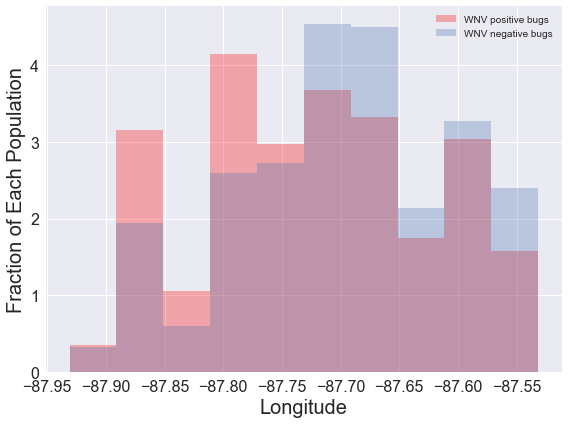

In [203]:
figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

train.loc[train['WnvPresent']==1]['east_west'].hist( alpha=.3, density=True, label = 'WNV positive bugs', color='red')
train.loc[train['WnvPresent']==0]['east_west'].hist( alpha=.3, density=True, label = 'WNV negative bugs',)
plt.legend(loc='upper right')
ax.set_xlabel('Longitude')
ax.set_ylabel('Fraction of Each Population')

plt.savefig("./timing.png")

# B. Bootstrap the WNV-positive data to generate balanced classes for training

In [204]:
train_positive=train.loc[train['WnvPresent']==1]

In [205]:
train_negative=train.loc[train['WnvPresent']==0]

In [206]:
train_positive.shape

(429, 60)

In [207]:
# We have 7,975 samples that are negative.  We need 7,546 extra samples of positive data
# to balance the classes

train_negative.shape[0]-train_positive.shape[0]

7546

In [208]:
# Sample the negative data to get 7,546 extra samples of positive data

train_positive_extra=train_positive.sample(n=7546, replace=True)

In [209]:
# Concat the positive, negative, and extra negative rows

train_oversample=pd.concat([train_positive, train_negative, train_positive_extra])

In [210]:
# Shuffle the rows

train_oversample=train_oversample.sample(frac=1)

# C. Generate feature matrix and target vector

In [211]:
y_train_o=train_oversample['WnvPresent'].values
y_train=train['WnvPresent'].values
y_test=test['WnvPresent'].values

In [403]:
# Cutting out the day and day^2 features, because probably too similar to the 
# day length features.  Also cutting out some of the street features that were
# less significant.

features= ['MIX',
       'PIPIENS', 'RESTUANS', 'recent_temps', 'min_recent_temps',
       'recent_precip', 'dist_to_standing_water', 'dist_to_spray',  
           'recent_day_length', 'day_length_2', 'recent_wind', 'east_west',
       ' W OHARE AIRPORT', ' N OAK PARK AVE', ' S DOTY AVE',
       ' N MILWAUKEE AVE', ' S KOSTNER AVE']

In [404]:
# o means a feature matrix from an oversampled set


X_train_o=train_oversample[features]
X_train=train[features]
X_test=test[features]
X_pred=pred[features]


# D. Try a Random Forest

In [223]:
rf=RandomForestClassifier()

## D.1., I got better results using the balanced class weights hyperparameter, and not using oversampled training observations.

In [236]:
hyperparameters={
                'n_estimators': [100],
                'max_depth': [20, 50, 100],
                'min_samples_split': [20, 25, 30],
                'class_weight': ['balanced']
}
                
rfgrid = GridSearchCV(rf, hyperparameters, cv=3, scoring='roc_auc')

In [237]:
rfgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': [20, 50, 100], 'min_samples_split': [20, 25, 30], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [238]:
rfgrid.best_params_

{'class_weight': 'balanced',
 'max_depth': 100,
 'min_samples_split': 30,
 'n_estimators': 100}

In [242]:
rfgrid.score(X_test, y_test)

0.8312924325219406

In [240]:
rfgrid.score(X_train, y_train)

0.9579567558877903

In [243]:
roc_auc_score(y_test, rfgrid.predict(X_test))

0.69784318595794

In [277]:
roc_auc_score(y_train, rfgrid.predict(X_train))

0.8929073225624949

## D.2 See what happens when you change the classification threshold

In [245]:
def threshold_predict(model, threshold, inputvals):
    return [1 if item[1]>threshold else 0 for item in model.predict_proba(inputvals)]

In [246]:
def score_model (model, modelname, threshold, Xvals, yvals):
    
    y_predict=threshold_predict(model, threshold, Xvals)
    
    conf=confusion_matrix(yvals, y_predict)
    
    print ("False Positive Rate", conf[0][1]/(conf[0][1]+conf[0][0]))
    
    print ("False Negative Rate", conf[1][0]/(conf[1][0]+conf[1][1]))
    
    print ("Accuracy", (conf[1][1]+conf[0][0])/(conf[1][1]+conf[0][0]+conf[1][0]+conf[0][1]))
    

In [247]:
score_model(rfgrid, "Random Forest", .1, X_test, y_test)

False Positive Rate 0.44646464646464645
False Negative Rate 0.08196721311475409
Accuracy 0.5746907706945766


In [251]:
score_model(rfgrid, "Random Forest", .2, X_test, y_test)

False Positive Rate 0.33131313131313134
False Negative Rate 0.1557377049180328
Accuracy 0.6788772597526166


In [248]:
score_model(rfgrid, "Random Forest", .3, X_test, y_test)

False Positive Rate 0.2515151515151515
False Negative Rate 0.2540983606557377
Accuracy 0.7483349191246432


In [249]:
score_model(rfgrid, "Random Forest", .4, X_test, y_test)

False Positive Rate 0.19292929292929292
False Negative Rate 0.3360655737704918
Accuracy 0.7987630827783063


In [250]:
score_model(rfgrid, "Random Forest", .5, X_test, y_test)

False Positive Rate 0.12070707070707071
False Negative Rate 0.48360655737704916
Accuracy 0.8582302568981922


## D.3. Find out what the Random Forest Model was focusing on

In [252]:
importance=rfgrid.best_estimator_.feature_importances_

In [253]:
importance

array([0.01866211, 0.01504639, 0.02644864, 0.0798729 , 0.0475455 ,
       0.04832971, 0.08016397, 0.08649149, 0.00513238, 0.00531606,
       0.00676672, 0.00409013, 0.00630343, 0.00242542, 0.11960089,
       0.1132571 , 0.08023764, 0.07938545, 0.06309012, 0.11183395])

In [254]:
explanation=pd.DataFrame({'features':features, 'importance':importance})

In [255]:
explanation.sort_values(by='importance', ascending=True)

,features,importance
13,N PULASKI RD,0.002425
11,N MILWAUKEE AVE,0.004090
8,W OHARE AIRPORT,0.005132
9,N OAK PARK AVE,0.005316
12,S KOSTNER AVE,0.006303
10,S DOTY AVE,0.006767
1,PIPIENS,0.015046
0,MIX,0.018662
2,RESTUANS,0.026449
4,min_recent_temps,0.047546


In [256]:

print(train.loc[train['WnvPresent']==1]['dist_to_spray'].mean())
print(train.loc[train['WnvPresent']==0]['dist_to_spray'].mean())


2.0733572212885703
2.323630532478759


In [257]:
print(train.loc[train['WnvPresent']==1]['dist_to_standing_water'].mean())
print(train.loc[train['WnvPresent']==0]['dist_to_standing_water'].mean())


1.1704312191125084
0.9838460696166562


# E. Support Vector Machine generating AUC score of .73, slightly better than Random Forest.  Also showing less overfitting than Random Forest.

In [ ]:
pipeline3 = Pipeline([
    
    ('ss', StandardScaler()),
    ('sv', svm.SVC())
])



In [261]:
hyperparameters={
            'sv__C':np.logspace(-4, 2, 3) ,   
            'sv__gamma': np.logspace(-4, 2, 3),
            'sv__class_weight': ['balanced'],
            'sv__probability': [True]
}
                
svcgrid = GridSearchCV(pipeline3, hyperparameters, cv=3, scoring='roc_auc')

In [262]:
# I didn't use the oversampled data because SVC has an alternate method of setting balanced
# class weightings, instead of using oversampled data.

svcgrid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sv', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sv__C': array([1.e-04, 1.e-01, 1.e+02]), 'sv__gamma': array([1.e-04, 1.e-01, 1.e+02]), 'sv__class_weight': ['balanced'], 'sv__probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [263]:
svcgrid.best_params_

{'sv__C': 0.1,
 'sv__class_weight': 'balanced',
 'sv__gamma': 0.1,
 'sv__probability': True}

In [264]:
svcgrid.score(X_train, y_train)

0.8478992480873359

In [265]:
svcgrid.score(X_test, y_test)

0.7998737373737373

In [266]:
roc_auc_score(y_test, svcgrid.predict(X_test))

0.7396754429541315

In [276]:
roc_auc_score(y_train, svcgrid.predict(X_train))

0.7822683064062375

In [267]:
score_model(rfgrid, "Random Forest", .1, X_test, y_test)

False Positive Rate 0.44646464646464645
False Negative Rate 0.08196721311475409
Accuracy 0.5746907706945766


In [268]:
score_model(rfgrid, "Random Forest", .2, X_test, y_test)

False Positive Rate 0.33131313131313134
False Negative Rate 0.1557377049180328
Accuracy 0.6788772597526166


In [269]:
score_model(rfgrid, "Random Forest", .3, X_test, y_test)

False Positive Rate 0.2515151515151515
False Negative Rate 0.2540983606557377
Accuracy 0.7483349191246432


In [270]:
score_model(rfgrid, "Random Forest", .4, X_test, y_test)

False Positive Rate 0.19292929292929292
False Negative Rate 0.3360655737704918
Accuracy 0.7987630827783063


In [271]:
score_model(rfgrid, "Random Forest", .5, X_test, y_test)

False Positive Rate 0.12070707070707071
False Negative Rate 0.48360655737704916
Accuracy 0.8582302568981922


# F. KNN doesn't work so well.  Lots of overfitting.

In [272]:
pipeline2 = Pipeline([
    
    ('ss', StandardScaler()),
    ('kn', KNeighborsClassifier())
])


In [281]:
hyperparameters={
                'kn__p': [1,2],
                'kn__n_neighbors': [1, 5,10, 20, 40]
}
                
knngrid = GridSearchCV(pipeline2, hyperparameters, cv=3, scoring='roc_auc')

In [282]:
# Using oversampled training data

knngrid.fit(X_train_o, y_train_o)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kn__p': [1, 2], 'kn__n_neighbors': [1, 5, 10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [283]:
knngrid.best_params_

{'kn__n_neighbors': 5, 'kn__p': 2}

In [284]:
knngrid.score(X_train_o, y_train_o)

0.9831877438311337

In [285]:
knngrid.score(X_test, y_test)

0.6753705083623116

In [295]:
roc_auc_score(y_test, knngrid.predict(X_test))

0.643591654247392

In [296]:
roc_auc_score(y_train, knngrid.predict(X_train))

0.9414195000401897

# G. Logistic Regression has comparable results to SVC.  Very little sign of overfitting.

In [405]:
ss=StandardScaler()

In [406]:
X_train_o=ss.fit_transform(X_train_o)

In [407]:
X_test=ss.transform(X_test)

In [408]:
lm=LogisticRegression(C=10, penalty='l1')

In [410]:
# Using oversampled training data

lm.fit(X_train_o, y_train_o)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [411]:
roc_auc_score(y_test, lm.predict(X_test))

0.7241347905282332

In [412]:
roc_auc_score(y_train_o, lm.predict(X_train_o))

0.7332288401253919

In [413]:
score_model(lm, "Logistic Regression", .1, X_test, y_test)

False Positive Rate 0.8378787878787879
False Negative Rate 0.0
Accuracy 0.21075166508087537


In [414]:
score_model(lm, "Logistic Regression", .2, X_test, y_test)

False Positive Rate 0.65
False Negative Rate 0.04918032786885246
Accuracy 0.38487155090390107


In [415]:
score_model(lm, "Logistic Regression", .3, X_test, y_test)

False Positive Rate 0.5287878787878788
False Negative Rate 0.08196721311475409
Accuracy 0.4971455756422455


In [416]:
score_model(lm, "Logistic Regression", .4, X_test, y_test)

False Positive Rate 0.42272727272727273
False Negative Rate 0.1557377049180328
Accuracy 0.5927687916270219


In [417]:
score_model(lm, "Logistic Regression", .5, X_test, y_test)

False Positive Rate 0.32222222222222224
False Negative Rate 0.22950819672131148
Accuracy 0.6831588962892483


In [418]:
score_model(lm, "Logistic Regression", .6, X_test, y_test)

False Positive Rate 0.2318181818181818
False Negative Rate 0.3442622950819672
Accuracy 0.7616555661274976


In [419]:
score_model(lm, "Logistic Regression", .7, X_test, y_test)

False Positive Rate 0.13686868686868686
False Negative Rate 0.5
Accuracy 0.8420551855375833


In [420]:
score_model(lm, "Logistic Regression", .8, X_test, y_test)

False Positive Rate 0.03434343434343434
False Negative Rate 0.8278688524590164
Accuracy 0.9196003805899143


In [421]:
score_model(lm, "Logistic Regression", .9, X_test, y_test)

False Positive Rate 0.005050505050505051
False Negative Rate 0.9344262295081968
Accuracy 0.9410085632730733


# G.1 What is the regression looking at?

In [422]:
coefs=lm.coef_

In [423]:
coefs=coefs.ravel()

In [424]:
explanation=pd.DataFrame({'features':features, 'coefs':coefs})

In [425]:
explanation.sort_values(by='coefs')

,coefs,features
9,-27.760369,day_length_2
11,-0.356549,east_west
6,-0.126009,dist_to_standing_water
5,-0.125405,recent_precip
10,-0.087258,recent_wind
4,-0.011098,min_recent_temps
7,0.000885,dist_to_spray
14,0.134067,S DOTY AVE
15,0.138428,N MILWAUKEE AVE
13,0.158750,N OAK PARK AVE
